In [1]:
# !pip install -U python-dateutil
# !pip install -U ipywidgets

In [1]:
from finlab.crawler import (
    widget, 
    
    crawl_price, 
    crawl_monthly_report, 
    crawl_finance_statement_by_date,
    crawl_legal_person,
    date_range, month_range, season_range,
    crawl_credit_TWSE,
  crawlOTCStocksInfo,CombineDBwidget,crawl_OTC_price
      #crawlOTC_monthly_report,  
)
from finlab.crawl_credit import (
    widget1, 
    
    crawl_credit, 
    
    date_range, month_range, season_range
)

import sqlite3
import os
conn = sqlite3.connect(os.path.join('data', "data.db"))

widget(conn, 'price', crawl_price, date_range)
widget(conn, 'monthly_revenue', crawl_monthly_report, month_range)
widget(conn, 'finance_statement', crawl_finance_statement_by_date, season_range)
widget(conn, 'legal_person', crawl_legal_person, date_range)#抓取法人資料
#widget(conn, 'credit', crawl_credit_TWSE, date_range) #抓取上櫃資料
widget1(conn, 'twii_credit', crawl_credit, date_range) #抓取券資比資料
widget(conn, 'OTC_price', crawl_OTC_price, date_range) #抓取上櫃資料，不過我也把它存在OTClab的data下
widget(conn, 'stocks_info', crawlOTCStocksInfo, date_range)#抓取除權息資訊
#widget(conn, 'monthly_revenue', crawlOTC_monthly_report, month_range)
CombineDBwidget()

start crawl finance_statement from  2018-11-14 to 2018-11-14


crawling 2018-11-14
http://mops.twse.com.tw/nas/t21/sii/t21sc03_107_8.html


parse htmls 2018 season 3 stock 1103:   0%|          | 2/930 [01:02<7:40:34, 29.78s/it]

**WARRN: requests cannot get stock 1103 .html


## 台股大盤

In [2]:
import requests
import pandas as pd
from io import StringIO
def crawl_twse_indices(date):
    
    headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:2.0.1) Gecko/2010010' \
    '1 Firefox/4.0.1',
    'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'Accept-Language':'en-us,en;q=0.5',
    'Accept-Charset':'ISO-8859-1,utf-8;q=0.7,*;q=0.7'}
    
    datestr = date.strftime('%Y%m%d')
    
    try:
        res = requests.post('http://www.twse.com.tw/indicesReport/MI_5MINS_HIST?response=csv&date=' + datestr , headers =headers)
        res1 = requests.post('http://www.twse.com.tw/exchangeReport/FMTQIK?response=csv&date=' + datestr)
    except:
        print('**WARRN: cannot get stock price at', datestr)
        return None
    
    content = res.text.replace('=', '')
    df = pd.read_csv(StringIO(content),header=1)
    df = df.dropna(axis=1,how='all')
   
    lines = content.split('\n')
    content = "\n".join(lines)
    df = pd.read_csv(StringIO(content),header=1)
    df = df.dropna(axis=1,how='all')
    content1 = res1.text.replace('=', '')
    lines1 = content1.split('\n')
    content1 = "\n".join(lines1)
    df1 = pd.read_csv(StringIO(content1),header=1)

    df1 = df1.dropna(axis=1,how='all')
    df1 = df1.dropna(axis=0,how='any')
    df1 = df1.rename(columns={'日期':'日期.1'})
    
    df2 = pd.concat([df,df1],axis=1)
    df2.drop(['日期.1'],axis=1,inplace=True)
    df2 = df2.astype(str)
    df2 = df2.apply(lambda s: s.str.replace(',', ''))
    df2 = df2.apply(lambda s: s.str.replace('/', ''))
    df2 = df2.apply(lambda s:pd.to_numeric(s, errors='coerce'))
    df2['日期'] = df2['日期'] + 19110000
    df2['日期'] = pd.to_datetime(df2['日期'].astype(str))
    df2['stock_id'] = 'TWSE'
    df2 = df2.rename(columns={'日期':'date'})
    df2 = df2.set_index(['stock_id', 'date'])
    df2
    
    return df2
from finlab.crawler import (
    widget, 
    date_range,month_range, season_range
)
import sqlite3
import os
conn = sqlite3.connect(os.path.join('data', "data.db"))
widget(conn, 'twse_indices',crawl_twse_indices, date_range)

start crawl twse_indices from  2018-11-01 to 2019-02-07


crawling 2018-11-01
success
crawling 2018-11-02
success
crawling 2018-11-03
success
crawling 2018-11-04
success
crawling 2018-11-05
success
crawling 2018-11-06
**WARRN: cannot get stock price at 20181106
fail, check if it is a holiday
crawling 2018-11-07
**WARRN: cannot get stock price at 20181107
fail, check if it is a holiday
crawling 2018-11-08


EmptyDataError: No columns to parse from file

In [11]:
import requests
import datetime
def crr(d):
    datestr = d.strftime('%Y%m%d')
    Y = int(datestr[:4])-1911
    Y = str(Y)
    M = datestr[4:6]
    D = datestr[6:]
    datestr = Y + '/' + M + '/' + D
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'}
    link = 'http://www.tpex.org.tw/web/stock/aftertrading/daily_close_quotes/stk_quote_download.php?l=zh-tw&d='+datestr+'&s=0,asc,0'
    r = requests.get(link , headers = headers )
    r.ok
    lines = r.text.replace('\r', '').split('\n')

    import pandas as pd
    from io import StringIO
    df = pd.read_csv(StringIO("\n".join(lines[3:])), header=None)
    df.head()
    df.columns = list(map(lambda l: l.replace(' ',''), lines[2].split(',')))
    df.index = df['代號']
    df = df.drop(['代號'], axis=1)
    df  = df[:-7]
    return df
d = datetime.date(2018,12,17)
df2 = crr(d)

In [8]:
from finlab.crawler import crawl_price
df1 = crawl_price(d)
df1.head()

,,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比
stock_id,date,,,,,,,,,,,,,
0050,2018-12-17,5652433,2331,428269261,75.35,76.05,75.15,75.95,0.60,75.90,42,75.95,308,0.0
0051,2018-12-17,15000,12,434920,28.90,29.08,28.90,29.00,0.16,29.00,10,29.15,1,0.0
0052,2018-12-17,99006,11,4794012,48.23,48.61,48.23,48.51,0.51,48.23,1,48.80,5,0.0
0053,2018-12-17,18000,6,553050,30.69,30.84,30.69,30.84,0.10,30.80,1,30.95,1,0.0
0054,2018-12-17,2000,2,39450,19.71,19.74,19.71,19.74,0.02,19.74,1,19.83,20,0.0


In [25]:
df = df2
df = df[:-7]
df

,名稱,收盤,漲跌,開盤,最高,最低,均價,成交股數,成交金額(元),成交筆數,最後買價,最後賣價,發行股數,次日參考價,次日漲停價,次日跌停價
代號,,,,,,,,,,,,,,,,
006201,元大富櫃50,11.11,+0.06,11.00,11.17,11.00,11.11,"82,000","910,720",27,11.10,11.11,"38,946,000",11.11,12.22,10.00
00679B,元大美債20年,37.61,+0.10,37.53,37.61,37.53,37.60,"480,211","18,054,294",100,37.57,37.61,"944,692,000",37.61,9999.95,0.01
00687B,國泰20年美債,39.18,+0.06,39.20,39.20,39.15,39.19,"23,208,000","909,519,280",9,39.14,39.19,"605,287,000",39.18,9999.95,0.01
00694B,富邦美債1-3,40.76,+0.04,40.79,40.79,40.75,40.76,"358,000","14,590,620",6,40.68,40.79,"91,076,000",40.76,9999.95,0.01
00695B,富邦美債7-10,39.29,+0.09,39.27,39.29,39.25,39.27,"318,378","12,502,929",13,39.25,39.29,"15,686,000",39.29,9999.95,0.01
00696B,富邦美債20年,39.88,+0.12,39.84,39.88,39.84,39.75,"2,907,000","115,555,140",10,39.75,39.86,"463,181,000",39.88,9999.95,0.01
00697B,元大美債7-10,39.39,+0.05,39.40,39.40,39.39,39.40,"450,000","17,727,800",5,39.38,39.41,"61,212,000",39.39,9999.95,0.01
00718B,富邦中國政策債,20.66,-0.10,20.79,20.79,20.66,20.68,"29,568,500","611,468,548",15,20.66,20.68,"965,001,000",20.66,9999.95,0.01
00719B,元大美債1-3,31.90,-0.02,31.90,31.94,31.90,31.90,"451,000","14,387,500",5,31.87,31.94,"6,514,000",31.90,9999.95,0.01


## 輸入年度與季度來取得年報資料

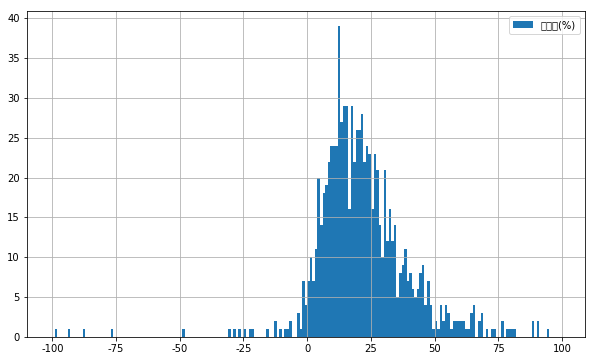

In [2]:
stock = financial_statement(107,3)
stock = stock.astype(float)
plt.rcParams['axes.unicode_minus']=False
fig = plt.figure(figsize=(10, 6))
stock['毛利率(%)'].hist(bins=range(-100,100) , label="毛利率(%)")
plt.legend()

In [3]:
cond1 = stock['毛利率(%)'] > 30
cond2 = stock['營業利益率(%)'] > 30
stock[cond1 & cond2]

,公司代號,營業收入,毛利率(%),營業利益率(%),稅前純益率(%),稅後純益率(%)
勤益投控,1437.0,434.71,73.08,54.80,59.56,49.08
川湖,2059.0,3255.00,52.63,39.43,49.20,39.61
為升,2231.0,3059.26,47.33,30.72,31.94,26.06
國巨,2327.0,60937.02,64.42,53.10,56.97,48.26
台積電,2330.0,741703.36,48.50,37.28,38.62,33.87
海悅,2348.0,793.23,62.96,43.62,44.87,44.71
南亞科,2408.0,67764.24,55.55,47.61,49.58,46.35
可成科技,2474.0,66251.43,42.15,32.69,47.15,31.80
華新科,2492.0,36076.10,59.88,52.36,53.43,42.92
宏盛,2534.0,7102.42,43.23,38.26,39.36,38.52


## Catch daily price

In [4]:
import requests
import pandas as pd
from io import StringIO

def crawl_price(date):
    
    # 將 date 變成字串 舉例：'20180525' 
    datestr = date.strftime('%Y%m%d')
    
    # 從網站上依照 datestr 將指定日期的股價抓下來
    r = requests.post('http://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALLBUT0999')
    
    # 將抓下來的資料（r.text），其中的等號給刪除
    content = r.text.replace('=', '')
    
    # 將 column 數量小於等於 10 的行數都刪除
    lines = content.split('\n')
    lines = list(filter(lambda l:len(l.split('",')) > 10, lines))
    
    # 將每一行再合成同一行，並用肉眼看不到的換行符號'\n'分開
    content = "\n".join(lines)
    
    # 假如沒下載到，則回傳None（代表抓不到資料）
    if content == '':
        return None
    
    # 將content變成檔案：StringIO，並且用pd.read_csv將表格讀取進來
    df = pd.read_csv(StringIO(content))
    
    # 將表格中的元素都換成字串，並把其中的逗號刪除
    df = df.astype(str)
    df = df.apply(lambda s: s.str.replace(',', ''))
    
    # 將爬取的日期存入 dataframe
    df['date'] = pd.to_datetime(date)
    
    # 將「證券代號」的欄位改名成「stock_id」
    df = df.rename(columns={'證券代號':'stock_id'})
    
    # 將 「stock_id」與「date」設定成index 
    df = df.set_index(['stock_id', 'date'])
    
    # 將所有的表格元素都轉換成數字，error='coerce'的意思是說，假如無法轉成數字，則用 NaN 取代
    df = df.apply(lambda s:pd.to_numeric(s, errors='coerce'))
    
    # 刪除不必要的欄位
    df = df[df.columns[df.isnull().all() == False]]
    
    return df


import datetime
# df = crawl_price(datetime.datetime(2018,10,16))
df = crawl_price(datetime.date.today())
#Save into my DB
import sqlite3
conn = sqlite3.connect(os.path.join('data', "data.db"))
df.to_sql('daily_price',conn,if_exists='append')
print('Done!')

In [2]:
import datetime
from finlab.crawler import update_table
#update_table(conn, 'price', crawl_price, [datetime.date(2018,3,26)])
#update_table(conn, 'monthly_revenue', crawl_monthly_report, [datetime.date(2018,3,1)])
#update_table(conn, 'finance_statement', crawl_finance_statement_by_date, [datetime.date(2018,3,31)])

In [9]:
# -*- coding: utf-8 -*-
import json
import time
from datetime import datetime
import pandas as pd
import scrapy

TWSE_URL = 'http://www.twse.com.tw/fund/T86?response=json&date={y}{m:02d}{d:02d}&selectType=ALL'
TPEX_URL = 'http://www.tpex.org.tw/web/stock/3insti/daily_trade/3itrade_hedge_result.php?l=zh-tw&se=AL&t=D&d={y}/{m:02d}/{d:02d}'

columns = ["_id",
           "外陸資買進",
           "外陸資賣出",
           "外陸資買賣超",
           "外資自營商買進",
           "外資自營商賣出",
           "外資自營商買賣超",
           "投信買進",
           "投信賣出",
           "投信買賣超",
           "自營商買進",
           "自營商賣出",
           "自營商買賣超",
           "自營商買進避險",
           "自營商賣出避險",
           "自營商買賣超避險",
           "三大法人買賣超"]


def parse_info(d, m):
    _id = m['date'] + '_' + d[0]
    if m['市場別'] == '上市':
        d.pop(11)
        d = d[2:]
        d = [int(x.replace(',', '')) / 1000 for x in d]
    else:
        del d[8:11]
        d = d[2:-1]
        d = [int(x.replace(',', '')) / 1000 for x in d]

    return dict(zip(columns, [_id, *d]))


class StockDaySpider(scrapy.Spider):
    name = 'stock_investor'

    custom_settings = {
        'DOWNLOAD_DELAY': 1,
        'CONCURRENT_REQUESTS': 1,
        'MONGODB_COLLECTION': 'stock_day',
        'MONGODB_ITEM_CACHE': 1,
        'MONGODB_HAS_ID_FIELD': True,
        'COOKIES_ENABLED': False
    }

    def __init__(self, beginDate=None, endDate=None, *args, **kwargs):
        super(StockDaySpider, self).__init__(beginDate=beginDate, endDate=endDate, *args, **kwargs)

    def start_requests(self):
        if self.beginDate and self.endDate:
            start = self.beginDate
            end = self.endDate
        else:
            date = datetime.today().strftime("%Y-%m-%d")
            start = date
            end = date

        for date in pd.date_range(start, end)[::-1]:
            today = '{}/{:02d}/{:02d}'.format(date.year, date.month, date.day)
            y = date.year
            m = date.month
            d = date.day

            url = TWSE_URL.format(y=y, m=m, d=d)
            time.sleep(8)
            yield scrapy.Request(url, meta={'date': today, '市場別': '上市'})
            y = y - 1911
            url = TPEX_URL.format(y=y, m=m, d=d)
            yield scrapy.Request(url, meta={'date': today, '市場別': '上櫃'})

    def parse(self, response):
        m = response.meta
        json_data = json.loads(response.text)

        if m['市場別'] == '上市':
            try:
                data = json_data['data']
                for d in data:
                    yield parse_info(d, m)
            except KeyError:
                pass
        else:
            try:
                data = json_data['aaData']
                for d in data:
                    yield parse_info(d, m)
            except KeyError:
                pass